In [1]:
import time
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
train_dataset=datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(),download=True)
test_dataset=datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(),download=True)
train_loader=DataLoader(dataset=train_dataset, batch_size=256,shuffle=True)
test_loader=DataLoader(dataset=test_dataset, batch_size=256,shuffle=False)

In [5]:
for images, labels in train_loader:
    print("Image dimensions: ",images.shape), # batch size, color chanel, size(h,w)
    print("Labels dimensions: ",labels.shape)   
    break

Image dimensions:  torch.Size([256, 1, 28, 28])
Labels dimensions:  torch.Size([256])


In [11]:
class MLP(torch.nn.Module):
    def __init__(self, num_features=784,num_hidden=100, classes=10):
        super(MLP, self).__init__()
        self.classes=classes
        self.layer1=torch.nn.Linear(num_features,num_hidden)
        self.layer1.weight.detach().normal_(0.0, 0.1) #mean and standard deviation
        self.layer1.bias.detach().zero_()


        self.layer2=torch.nn.Linear(num_hidden,classes)
        self.layer2.weight.detach().normal_(0.0, 0.1)
        self.layer2.bias.detach().zero_()
    
    def forward(self, x):
        out=self.layer1(x)
        out=functional.relu(out)
        logits=self.layer2(out)
        probs = functional.softmax(logits, dim=1)
        return logits, probs
    



In [26]:
def accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        _,probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            logits,probs = net(features)
            loss = functional.cross_entropy(logits, targets)
            curr_loss += loss
        return float(curr_loss)/cnt
    


In [27]:
def train(model,epochs=20):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    start = time.time()
    batch_loss= []
    epoch_loss = []
    total_batches=len(train_dataset)/256
    for epoch in range(epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
                
            logits, _ = model(features)
            
            loss = functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
            
            ### LOGGING
            batch_loss.append(loss.item())
            if not batch_idx % 50:
                print (f"Epoch: {epoch}/ {epochs} | Batch: {batch_idx} / {total_batches}  | Cost: {loss:.4f}")
            
        loss = compute_loss(model, train_loader)
        acc = accuracy(model, train_loader)
        epoch_loss.append(loss)
        print(f'Epoch: {epoch}/{epochs}  | Train Cost: {loss}  | Accuracy: {acc}')
        te=(time.time() - start)
        print(f'Time elapsed: {te:.4f}')
        total_t=time.time() - start
    print(f'Total Training Time: {total_t:.4f}' )
    return epoch_loss,batch_loss


In [28]:
%%time
model=MLP().to(device)

loss, batch_loss=train(model, epochs=20)

Epoch: 0/ 20 | Batch: 0 / 234.375  | Cost: 2.4234
Epoch: 0/ 20 | Batch: 50 / 234.375  | Cost: 0.6747
Epoch: 0/ 20 | Batch: 100 / 234.375  | Cost: 0.6011
Epoch: 0/ 20 | Batch: 150 / 234.375  | Cost: 0.4067
Epoch: 0/ 20 | Batch: 200 / 234.375  | Cost: 0.3656
Epoch: 0/20  | Train Cost: 0.396363771878756  | Accuracy: 88.44666290283203
Time elapsed: 23.4449
Epoch: 1/ 20 | Batch: 0 / 234.375  | Cost: 0.3766
Epoch: 1/ 20 | Batch: 50 / 234.375  | Cost: 0.3438
Epoch: 1/ 20 | Batch: 100 / 234.375  | Cost: 0.2996
Epoch: 1/ 20 | Batch: 150 / 234.375  | Cost: 0.3123
Epoch: 1/ 20 | Batch: 200 / 234.375  | Cost: 0.3549
Epoch: 1/20  | Train Cost: 0.31191631871410924  | Accuracy: 91.16500091552734
Time elapsed: 46.1216
Epoch: 2/ 20 | Batch: 0 / 234.375  | Cost: 0.3100
Epoch: 2/ 20 | Batch: 50 / 234.375  | Cost: 0.2726
Epoch: 2/ 20 | Batch: 100 / 234.375  | Cost: 0.2636
Epoch: 2/ 20 | Batch: 150 / 234.375  | Cost: 0.2546
Epoch: 2/ 20 | Batch: 200 / 234.375  | Cost: 0.3454
Epoch: 2/20  | Train Cost: 0.28

In [29]:
import matplotlib.pyplot as plt

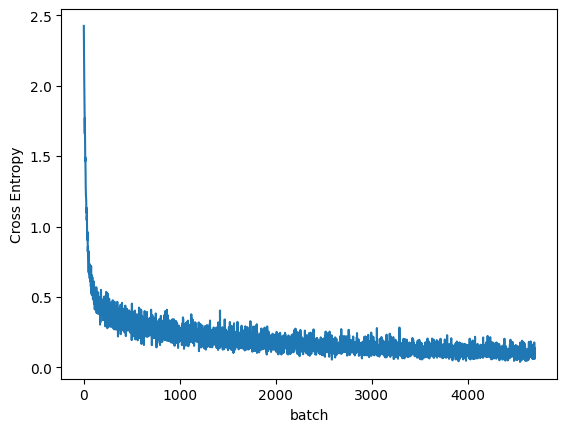

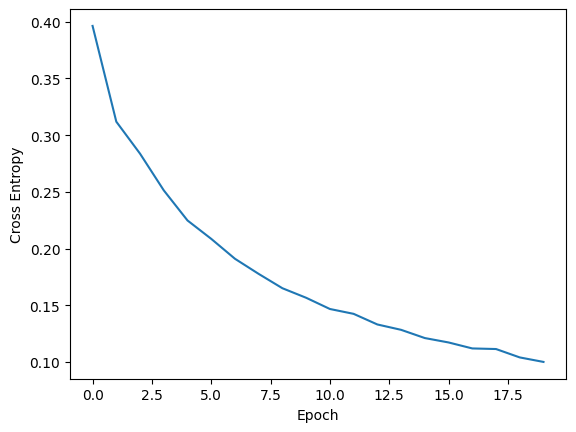

In [32]:
plt.plot(range(len(batch_loss)), batch_loss)
plt.ylabel('Cross Entropy')
plt.xlabel('batch')
plt.show()

plt.plot(range(len(loss)), loss)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [34]:
print('Test accuracy: ', accuracy(model, test_loader))

Test accuracy:  tensor(96.7400, device='cuda:0')
